In [1]:
from os.path import expanduser
import os


def load_env():
    home = expanduser("~")
    print(home)
    with open(home+'/.env', 'r') as f:
        env = dict()
        for line in f.readlines():
            key, value = line.split('=')
            env[key] = value.split('\n')[0]
        return env

def export_env():
    """Loads your .env file and exports the three variables important for mlflow.
    MLFLOW_TRACKING_USERNAME, MLFLOW_TRACKING_PASSWORD, MLFLOW_TRACKING_URI
    """
    env = load_env()
    for key in ["MLFLOW_TRACKING_USERNAME", "MLFLOW_TRACKING_PASSWORD", "MLFLOW_TRACKING_URI"]:
        os.environ[key] = env[key]

In [2]:
### RUN FIRST:
### sudo openvpn --config kit.ovpn

import mlflow
from mlflow_utils.load_env import export_env

export_env()
mlflow.set_experiment("demo")

In [3]:
import pysftp
import paramiko
import os
import numpy as np

class GDB9_data_instance:
    def __init__(self, path):
        if not os.path.exists(path):
            raise Exception("Path {} does not exist.".format(path))
        with open(path, 'r') as f:
            num_of_atoms = int(f.readline())
            self.scalar_properties = f.readline().strip().replace("gdb ","").split("\t")
            self.scalar_properties = [float(p) for p in self.scalar_properties]
            self.scalar_properties[0] = int(self.scalar_properties[0])
            self.atoms = []
            for i in range(num_of_atoms):
                atom_posXYZ_MullikenPartialCharge = f.readline().strip().replace(" ","").replace("*^","e").split("\t")
                self.atoms.append(atom_posXYZ_MullikenPartialCharge)
            self.harmonic_vibrational_frequencies = f.readline().strip().split("\t")
            (self.gdb17_smile, self.b3lyp_relaxation_smile) = f.readline().strip().split("\t")
            (self.corina_InChI, self.b3lyp_InChI) = f.readline().strip().split("\t")
        
        
gdb9_data_dir = r"dsgdb9nsd"
gdb9_data = []
amount = 1000
currently_checked = 0

config = paramiko.config.SSHConfig()
config.parse(open(os.path.expanduser('~/.ssh/config')))
conf = config.lookup('lsdf')
with pysftp.Connection(host=conf['hostname'], username=conf['user'], private_key=conf['identityfile'][0]) as sftp:
    dataset_path = '/lsdf/kit/iti/projects/aimat-mlflow/datasets/dsgdb9nsd'
    with sftp.cd(dataset_path):
        #returned = sftp.execute('ls | wc -l')
        #sftp.chdir(dataset_path)
        cmd = 'cd ' + dataset_path + ' && ls | wc -l'
        returned = sftp.execute(cmd)
        num_files = [int(r.decode()) for r in returned][0]
        print("Number of files in the dataset: {}".format(num_files))
        for file in sftp.listdir():
            if len(gdb9_data) >= amount or currently_checked >= amount:
                break
            if file.endswith(".xyz"):
                currently_checked += 1
                #print(file)
                file_path = os.path.join(dataset_path, file)
                local_dir = os.getcwd() + '/data/' + gdb9_data_dir
                if not os.path.exists(local_dir):
                    os.makedirs(local_dir)
                local_path = os.path.join(local_dir, file)
                if not os.path.exists(local_path):
                    sftp.get(file_path, local_path)
                gdb9_data.append(GDB9_data_instance(local_path))

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of files in the dataset: 133885


In [4]:
smiles = [d.gdb17_smile for d in gdb9_data]
#smiles

In [5]:
homo_energies = np.array([d.scalar_properties[6] for d in gdb9_data])
#homo_energies

In [6]:
import rdkit.Chem as Chem

fps = np.array([np.array(Chem.RDKFingerprint(Chem.MolFromSmiles(smi))).astype(float)
                                    for smi in smiles])
#fps

In [7]:
train_features = fps
#test_features = 

train_labels = homo_energies
#test_labels = 

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curve(title, train_scores, test_scores, fit_times, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

mlflow.sklearn.autolog()

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

#model = MLPRegressor(random_state=1, max_iter=300)
model = RandomForestRegressor()

with mlflow.start_run() as run:
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(model, train_features, train_labels, cv=cv, n_jobs=None, return_times=True)

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021/01/27 14:54:42 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under sftp://lsdf/kit/iti/projects/aimat-mlflow/artifacts/1/16afc20230e04b61afe530ec6303efd8/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.
2021/01/27 14:54:45 WARNING mlflow.models.model: Logging model metadata to the tracking ser

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'matplotlib.pyplot' from '/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/matplotlib/pyplot.py'>

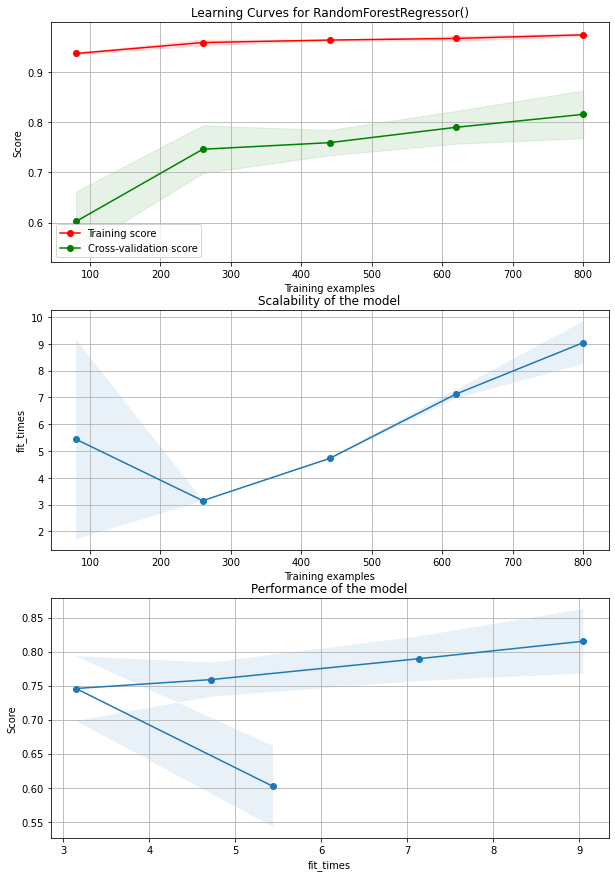

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves for " + str(model)

plot_learning_curve(title, train_scores, test_scores, fit_times, 
                    #axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4, train_sizes=train_sizes)
                    axes=axes, cv=cv, n_jobs=4, train_sizes=train_sizes)

## saving the current figure if neccesary ##
# plt.savefig('foo.png')

In [11]:
from pprint import pprint

def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

pprint(params)
pprint(metrics)
pprint(tags)
pprint(artifacts)

/home/erik/miniconda2/envs/automol/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'bootstrap': 'True',
 'ccp_alpha': '0.0',
 'criterion': 'mse',
 'max_depth': 'None',
 'max_features': 'auto',
 'max_leaf_nodes': 'None',
 'max_samples': 'None',
 'min_impurity_decrease': '0.0',
 'min_impurity_split': 'None',
 'min_samples_leaf': '1',
 'min_samples_split': '2',
 'min_weight_fraction_leaf': '0.0',
 'n_estimators': '100',
 'n_jobs': 'None',
 'oob_score': 'False',
 'random_state': 'None',
 'verbose': '0',
 'warm_start': 'False'}
{'training_mae': 0.0032379636374007797,
 'training_mse': 3.363651120967902e-05,
 'training_r2_score': 0.970823443472692,
 'training_rmse': 0.005799699234415439,
 'training_score': 0.970823443472692}
{'estimator_class': 'sklearn.ensemble._forest.RandomForestRegressor',
 'estimator_name': 'RandomForestRegressor'}
['model/MLmodel', 'model/conda.yaml', 'model/model.pkl']


In [12]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.